In [ ]:
%%bash
if ! conda env list | grep microexpressions; then
    conda env create -f environment.yml
else
    conda env update -f environment.yml
fi
conda activate microexpressions
dvc pull

In [2]:
import sys
import os
PROJ_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJ_PATH)

Device: cuda:0

image 1/1 d:\microexpressions\data\raw\celeba\img_align_celeba\000021.jpg: 640x544 1 face, 44.7ms
Speed: 4.6ms preprocess, 44.7ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 544)


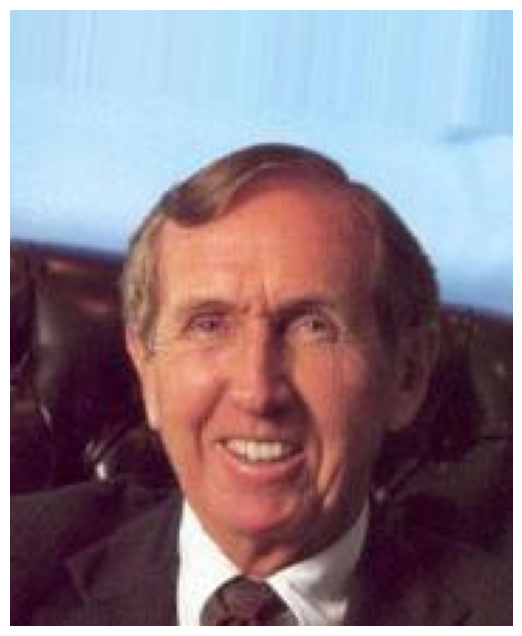

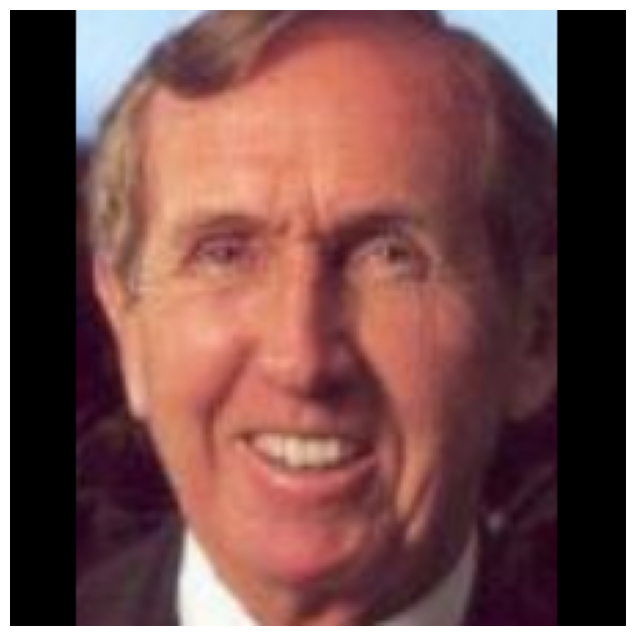

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from src.alignment import detect_faces, align_face

PROJ_PATH = os.getcwd()
DATA_DIR = os.path.join(PROJ_PATH, 'data')
MODEL_DIR = os.path.join(PROJ_PATH, 'models')

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

image_path = os.path.join(DATA_DIR, "raw", r"celeba\img_align_celeba", "000021.jpg")
model_path = os.path.join(MODEL_DIR, "yolov8n-face.pt")
image, detections = detect_faces(image_path, model_path, device)

# for det in detections:
#     x1, y1, x2, y2 = map(int, det["bbox"])
#     cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)
#     for x, y in det["landmarks"]:
#         cv2.circle(image, (int(x), int(y)), 1, (0, 0, 255), -1)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

aligned_image = align_face(image, np.array(detections[0]["landmarks"]), detections[0]["bbox"], output_size=(224, 224))
cv2.imwrite(r"D:\example_faces\s.jpg", aligned_image)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [29]:
from src.landmarks import get_landmarks

get_landmarks(r"D:\example_faces", r"D:\example_faces_out", r"D:\microexpressions\models\facexformer.pt", "facexformer", "cuda:0", 32, "D:\microexpressions\models\meanface.txt")

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\SL-2577\AppData\Local\Temp\ipykernel_61896\550945447.py:3: SyntaxWarning: invalid escape sequence '\m'
  get_landmarks(r"D:\example_faces", r"D:\example_faces_out", r"D:\microexpressions\models\facexformer.pt", "facexformer", "cuda:0", 32, "D:\microexpressions\models\meanface.txt")
d:\microexpressions\src\landmarks.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mo

In [30]:
get_landmarks(r"D:\example_faces", r"D:\example_faces_out", r"D:\microexpressions\models\pipnet.pth", "pipnet", "cuda:0", 32, "D:\microexpressions\models\meanface.txt")

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\SL-2577\AppData\Local\Temp\ipykernel_61896\777398444.py:1: SyntaxWarning: invalid escape sequence '\m'
  get_landmarks(r"D:\example_faces", r"D:\example_faces_out", r"D:\microexpressions\models\pipnet.pth", "pipnet", "cuda:0", 32, "D:\microexpressions\models\meanface.txt")
c:\Users\SL-2577\miniconda3\envs\microexpressions\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SL-2577\miniconda3\envs\microexpressions\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DE

In [26]:
import pandas as pd
import os
import cv2
import torch
import mlflow

def demo_landmark(model_type):
    df = pd.read_hdf(f"D:\example_faces_out\landmarks_{model_type}.h5")
    def plot_landmarks_cv2(image_path, landmarks):
        img = cv2.imread(image_path)
        img_height, img_width = img.shape[:2]
        for i in range(len(landmarks) // 2): 
            x = int(((landmarks[f"x{i}"] + 1) / 2) * img_width)
            y = int(((landmarks[f"y{i}"] + 1) / 2)  * img_height)
            cv2.circle(img, (x, y), radius=1, color=(0, 0, 255), thickness=-1)
        return img

    mlflow.set_experiment("landmark_examples")
    with mlflow.start_run():
        mlflow.log_param("model_type", model_type)
        for i in range(df.shape[0]):
            row = df.iloc[i]
            filename = row["filename"]
            image_path = os.path.join(r"D:\example_faces", filename)
            img = plot_landmarks_cv2(image_path, row)
            output_file = os.path.join(r"D:\example_faces_out", f"{model_type}_{filename}")
            cv2.imwrite(output_file, img)
            mlflow.log_artifact(output_file)


<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
C:\Users\SL-2577\AppData\Local\Temp\ipykernel_61896\2464089400.py:8: SyntaxWarning: invalid escape sequence '\e'
  df = pd.read_hdf(f"D:\example_faces_out\landmarks_{model_type}.h5")


In [32]:
demo_landmark("pipnet")